In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import nltk
import spacy
import pandas as pd
import tqdm
import string
!pip install nlp
import nlp
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
!pip install openai
import openai
!pip install seaborn
import seaborn as sns
%matplotlib inline
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 2.4 MB/s eta 0:00:01
   ---- ----------------------------------- 0.2/1.7 MB 1.5 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.7 MB 1.7 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/1.7 MB 1.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 1.9 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.7 MB 1.9 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 1.8 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.9 MB/s eta 0:00:01
   --------------------------- ------------ 1.2/1.7 MB 1.9 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 1.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.3/1.7 MB 1.9 MB/s eta 0:00:01
   ----------------

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joshp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joshp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data loading and processing

In [5]:

# Converts stars into categories, good bad or average
def categorize_review(row):

    try:
        stars = float(row['stars'])
        if stars >= 3.5:
            return 2
        elif stars > 2:
            return 1
        else:  # For 1 or 2 stars
            return 0
    except:
        return 0


def load_data(file_path):
    data = []

    with open(file_path, 'r', encoding="utf-8") as file:
        for line in file:
            data.append(json.loads(line))

    df = pd.DataFrame(data)

    df['category'] = df.apply(categorize_review, axis=1)

    #print(df)

    return df

def load_data_kaggle():

    file_path = "../reviews/reviews_kaggle.csv"

    df = pd.read_csv(file_path)

    # rename column
    df = df.rename(columns={"Review" : "review", "Rating":"stars"})

    #df['category'] = df.apply(categorize_review, axis=1)

    # Clean nan fields
    df = df[df['review'].notna() & (df['review'] != '')]
    
    return df
    

In [6]:
df = load_data("../reviews/reviews_UK.jsonl")

# Find the percentage of reviews in each star rating 
total_len = df.size
print(total_len)

print(df["stars"].value_counts())



2409
stars
5    456
4    133
1    115
3     52
2     47
Name: count, dtype: int64


# Sentiment Analysis Calculation

In [7]:
# Creates column of vader scores
def vader(df):
    sia = SentimentIntensityAnalyzer()

    df["vader"] = None
    for index, row in df.iterrows():
        # Use the polarity_scores method to get the sentiment
        sentiment_dict = sia.polarity_scores(row["review"])
        df.at[index, "vader"] = sentiment_dict["compound"]
    
    return df

# Creates column of textblob polarity and subjectivity
def text_blob(df):

    df['blobpolar'] = None
    df['blobsubj'] = None
    
    for index, row in df.iterrows():
        blob = TextBlob(row["review"])
    
        # Get the sentiment of the text
        sentiment = blob.sentiment
        df.at[index, "blobpolar"] = sentiment[0]
        df.at[index, "blobsubj"] = sentiment[1]

    return df

# Creates column of bert label and score
def bert(df):
    sentiment_pipeline = pipeline("sentiment-analysis")
    
    df['bert_label'] = None
    df['bert_score'] = None
    
    
    for index, row in df.iterrows():
        sentiment_result = sentiment_pipeline(row["review"])
        
        label_text = sentiment_result[0]['label']
        if label_text == "NEGATIVE":
            label = 0
        else:
            label = 1
        
        df.at[index, "bert_label"] = label
        df.at[index, "bert_score"] = sentiment_result[0]['score']
        if index % 100 == 0:
            print(index)
    
    return df

# Sentiment Prediction using Machine Learning

In [8]:
def ml(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    #print(y_test)
    #print(y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    print(confusion_matrix(y_test, y_pred))

# Load data and apply sentiment tools

file_paths = ["../reviews/reviews_UK.jsonl", "../reviews/reviews_USA.jsonl"]

for file_path in file_paths:
    df = load_data(file_path)
    df= vader(df)
    df = text_blob(df)
    df = bert(df)

    print(file_path)
    
    X = df[["blobpolar","blobsubj"]]
    y = df["category"]
    
    print("BLOB CLASSIFICATION")
    print()
    ml(X,y)
    
    print("BERT CLASSIFICATION")
    print()
    X = df[["bert_label", "bert_score"]]
    ml(X,y)
    
    print("VADER CLASSIFICATION")
    print()
    X = df[["vader"]]
    ml(X,y)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


0
100
200
300
400
500
600
700
800
../reviews/reviews_UK.jsonl
BLOB CLASSIFICATION

Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.73      0.69      0.71        32
           1       0.00      0.00      0.00         8
           2       0.89      0.96      0.92       121

    accuracy                           0.86       161
   macro avg       0.54      0.55      0.54       161
weighted avg       0.81      0.86      0.83       161

[[ 22   0  10]
 [  3   0   5]
 [  5   0 116]]
BERT CLASSIFICATION

Accuracy: 0.8322981366459627
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        32
           1       0.10      0.12      0.11         8
           2       0.94      0.91      0.92       121

    accuracy                           0.83       161
   macro avg       0.57      0.58      0.58       161
weighted avg       0.85      0.83      0.84       161

[[ 23   3   6]
 [  6   1   1]


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


0
100
200
300
400
500
600
700
../reviews/reviews_USA.jsonl
BLOB CLASSIFICATION

Accuracy: 0.7610062893081762
              precision    recall  f1-score   support

           0       0.36      0.25      0.30        16
           1       0.25      0.14      0.18        21
           2       0.84      0.93      0.88       122

    accuracy                           0.76       159
   macro avg       0.48      0.44      0.45       159
weighted avg       0.71      0.76      0.73       159

[[  4   5   7]
 [  3   3  15]
 [  4   4 114]]
BERT CLASSIFICATION

Accuracy: 0.7924528301886793
              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.30      0.33      0.32        21
           2       0.89      0.89      0.89       122

    accuracy                           0.79       159
   macro avg       0.64      0.62      0.63       159
weighted avg       0.80      0.79      0.79       159

[[ 10   3   3]
 [  4   7  10]
 [ 

## Graphing

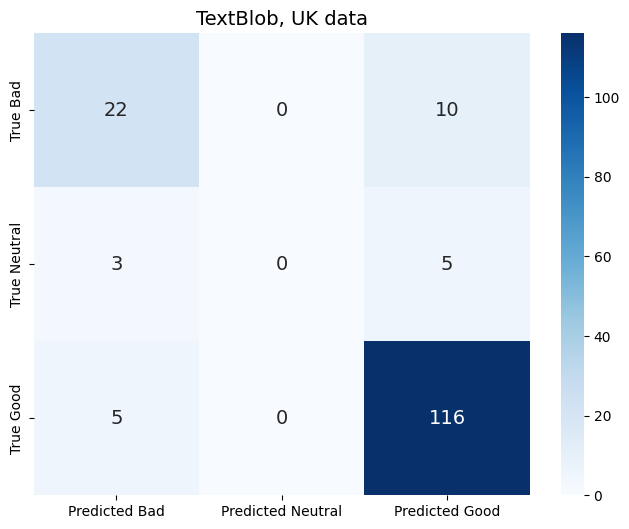

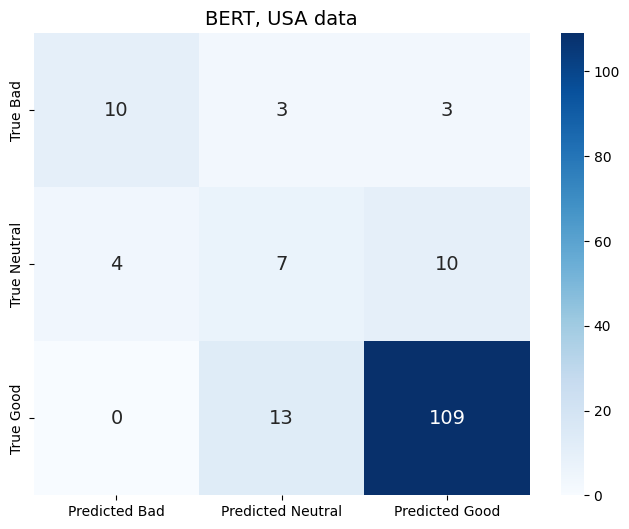

In [9]:

# Draws heatmap for confusion matrix
def confusion_heatmap(confusion_matrix, title):
    plt.figure(figsize=(8, 6))

    heatmap_large_font = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
    heatmap_large_font.set_title(title, fontsize=14)
    heatmap_large_font.set_xticklabels(['Predicted Bad', 'Predicted Neutral', 'Predicted Good'], fontsize=10)
    heatmap_large_font.set_yticklabels(['True Bad', 'True Neutral', 'True Good'], fontsize=10)
    plt.show()

blob_matrix_uk = np.array([
    [22, 0, 10],
    [3, 0, 5],
    [5, 0, 116]
])

bert_matrix_us = np.array(
    [[10,3,3],
     [4, 7,10],
     [0,13 ,109]])


confusion_heatmap(blob_matrix_uk, "TextBlob, UK data")
confusion_heatmap(bert_matrix_us, "BERT, USA data")


# Lexical Analysis

Some of these functions were not used in the report due to not returning useful enough results.
They have been kept in for the interest of completeness

In [10]:
def bert_topic(data):
    #topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

    reviews = [d["review"] for d in data]

    #print(reviews)

    # Initialize BERTopic model
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

    # Fit the model
    topics, probabilities = topic_model.fit_transform(reviews)

    # Extracted topics and their sizes
    topic_freq = topic_model.get_topic_freq()
    print(topic_freq.head())

    # Get the top 10 topics
    for topic in topic_freq['Topic'][1:11]:  
        print(f"Topic {topic}:")
        print(topic_model.get_topic(topic))


def preprocess(text):
    #print(text)
    
    # Convert text to lowercase
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans('','', string.punctuation))
    
    # Tokenize the text
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    
    # Remove stop words and rejoin into a single string
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])

    # Convert text to lowercase    
    
    return filtered_text

# Function to extract adjectives from a single document
def extract_adjectives(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    
    adjectives = [word for word, pos in tags if pos.startswith('JJ')]
    
    return adjectives

# Get list of most common adjectives
def common_adjectives(df):
    adjectives_list = [adjective for sublist in df['adjectives'] for adjective in sublist]
    adjective_counts = Counter(adjectives_list)
    most_common_adjectives = adjective_counts.most_common()
    return most_common_adjectives[:15]


def analyse_word_freq(df):
    # Add a space to the end of each review
    # Helps with splitting later
    df["reviews_clean"] = df["reviews_clean"] + " "

    # Split into three seperate DFs
    bad_df = df[df['category'] == 0]
    mid_df = df[df['category'] == 1]
    good_df = df[df['category'] == 2]

    # Flatten into list of words
    #low_words = [word for sublist in bad_df['reviews_clean']]
    #mid_words = [word for sublist in mid_df['reviews_clean'] for word in sublist]
    #high_words = [word for sublist in good_df['reviews_clean'] for word in sublist]

    bad_words = " ".join(bad_df['reviews_clean'])

    # Remove punctuation and split the string into words
    bad_words = re.findall(r'\b\w+\b', bad_words)
    
    print(bad_words)
    bad_freq = Counter(bad_words)
    print(bad_freq.most_common(50))

def LDA(df):

    # Vectorise the text
    new_stop_words = ["food","good"]
    vectorizer = CountVectorizer(stop_words=new_stop_words)
    dtm = vectorizer.fit_transform(df['reviews_clean'])

    # Fit topics
    n_topics = 5 
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)

    feature_names = vectorizer.get_feature_names_out()
    
    # Displaying Topics and Top Words in Each Topic
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-4:-1]  
        top_features = [feature_names[i] for i in top_features_ind]
        topics[f"Topic {topic_idx + 1}"] = top_features
    
    print(topics)

# Load kaggle dataset
df = load_data_kaggle()

df['category'] = df.apply(categorize_review, axis=1)

df['reviews_clean'] = df['review'].apply(lambda x: preprocess(x))
df['adjectives'] = df['reviews_clean'].apply(lambda x: extract_adjectives(x))

# Split dataset into good and bad reviews
bad_df = df[df['category'] == 0]
good_df = df[df['category'] == 2]


print(common_adjectives(bad_df))
print(common_adjectives(good_df))




[('good', 733), ('bad', 520), ('worst', 431), ('pathetic', 176), ('chicken', 132), ('much', 120), ('table', 116), ('great', 116), ('disappointed', 112), ('poor', 110), ('main', 107), ('horrible', 101), ('average', 92), ('dont', 89), ('less', 86)]
[('good', 5090), ('great', 1601), ('nice', 1140), ('best', 1086), ('awesome', 608), ('delicious', 571), ('overall', 478), ('main', 370), ('excellent', 360), ('chicken', 334), ('tasty', 327), ('special', 313), ('friendly', 309), ('little', 305), ('fish', 304)]


# Topic Detection

In [11]:
from openai import OpenAI
client = OpenAI()

# Define the initial system message
system_message = {
    "role": "system",
    "content": "Classify topics in reviews. There are 5 available topics: Food Quality, Service Quality, Hygiene, Restaurant Ambiance, and Price. Return a JSON object for each review you are given, with True if the topic is present and False if not."
}

#classify reviews using keyword detection
# returns dict of true or false for each catagory
def classify_review_keywords(review):
    # Keywords for each category
    keywords = {
        'food': ['delicious', 'savory', 'delectable', 'tasty', 'flavorful', 'fresh','disgusting'],
        'service': ['attentive', 'friendly', 'welcoming', 'helpful', 'courteous','rude','slow','unhelpful'],
        'hygiene': ['clean', 'sanitary', 'spotless', 'unhygienic','dirty'],
        'ambiance': ['cozy', 'stylish', 'pleasant', 'charming', 'atmospheric','cold','bright','damp'],
        'price': ['affordable', 'pricey', 'cheap', 'expensive', 'reasonable', 'overpriced']
    }

    # Initialize the results dictionary with False values
    categories_detected = {category: False for category in keywords}

    # Convert the review to lowercase
    review_lower = review.lower()

    # Check if any keyword is in the review
    for category, words in keywords.items():
        if any(word in review_lower for word in words):
            categories_detected[category] = True

    return categories_detected

# Function to classify a single review using the GPT 3.5 API
# returns dict of true or false for each catagory
def classify_review_gpt(review):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            system_message,
            {"role": "user", "content": review}
        ]
    )
    output = completion.choices[0].message.content 
    json_object = json.loads(output)
    #print(json_object)
    return json_object

#classify_review("Undoubtedly the best place to have ice creams nowadays is Cream stone. Near to DLF and many hostels. Polite staff and friendly. Always crowded")

In [12]:

# Creates boolean columns for each catagory labelled by keyword detection
def keyword_topics(df):
    # create rows for each catagory
    df["food"] = None
    df["service"] = None
    df["hygiene"] = None
    df["ambiance"] = None
    df["price"] = None

    fields = ["food", "service", "hygiene", "ambiance", "price"]

    for row_index, row in df.head(1000).iterrows():
        classification_result = list(classify_review_keywords(row['review']).values())
    
        for i in range(len(fields)):
            df.at[row_index, fields[i]] = classification_result[i]

    return df

# Creates boolean columns for each catagory labelled by GPT detection
def gpt_topics(df):
    # create rows for each catagory
    df["food"] = None
    df["service"] = None
    df["hygiene"] = None
    df["ambiance"] = None
    df["price"] = None
    
    fields = ["food", "service", "hygiene", "ambiance", "price"]
    
    for row_index, row in df.iloc[1000:3000].iterrows():
        try:
            classification_result = list(classify_review_gpt(row['review']).values())
            for i in range(len(fields)):
                try:
                    df.at[row_index, fields[i]] = classification_result[i]
                except Exception as e: 
                    print(e)
                    print("ERROR" + str(classification_result))
    
            # Saves to file every 50 rows in case of a fatal error
            if row_index %50 == 0:
                print(row_index)
                filestring = "classified_reviews"+str(row_index)+".csv"
                try:
                    df.to_csv(filestring, index=False)
                except Exception as e:
                    print(e)
        except Exception as e:
            print(e)


## Analyse topics

In [14]:
def num_topic_present(df):

    fields = ["food", "service", "hygiene", "ambiance", "price"]
    
    df = df[fields]
    df = df.dropna()

    freqs = []
    
    for field in fields:
        #print(df[field])
        freqs.append(int(df[field].sum(axis=0)))
    return freqs

# Creates dataframe labelled by keywords
df_keyword_topics = keyword_topics(df)
num_keyword_topics = num_topic_present(df_keyword_topics.head(2000))

# Loads GPT labelled dataframe
df_gpt_topics = pd.read_csv('classified_reviews_final.csv')
num_gpt_topics = num_topic_present(df_gpt_topics)


### Plotting

Plots percentage of each catagory present in reviews

[184, 134, 15, 33, 39]
[1548, 1102, 95, 778, 287]


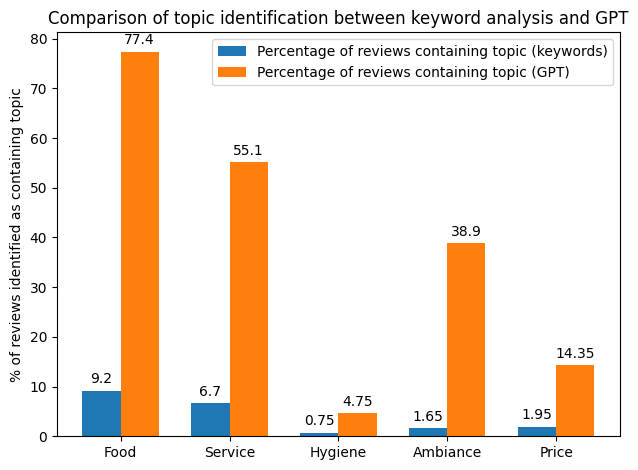

In [19]:
print(num_keyword_topics)
print(num_gpt_topics)

pct_keyword_topics = [(num_topic/2000) * 100 for num_topic in num_keyword_topics]
pct_gpt_topics = [(num_topic/2000) * 100 for num_topic in num_gpt_topics]


fields = ["Food", "Service", "Hygiene", "Ambiance", "Price"]

x = np.arange(len(fields))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pct_keyword_topics, width, label='Percentage of reviews containing topic (keywords)')
rects2 = ax.bar(x + width/2, pct_gpt_topics, width, label='Percentage of reviews containing topic (GPT)')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('% of reviews identified as containing topic')
ax.set_title('Comparison of topic identification between keyword analysis and GPT')
ax.set_xticks(x)
ax.set_xticklabels(fields)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [16]:
df = df_gpt_topics 

df['category'] = df.apply(categorize_review, axis=1)

# Split dataset into good and bad reviews
bad_df = df[df['category'] == 0]
good_df = df[df['category'] == 2]

# Find num in catagory 
num_bad_topics = num_topic_present(bad_df)
num_good_topics = num_topic_present(good_df)


print(num_bad_topics)
print(num_good_topics)

num_rows_bad = bad_df.shape[0]
num_rows_good = good_df.shape[0]

# Get percentage of topic in each dataset
pct_bad_topics = [int((num_topic / num_rows_bad) * 100) for num_topic in num_bad_topics]
pct_good_topics = [int((num_topic / num_rows_good) * 100) for num_topic in num_good_topics]

print(pct_bad_topics)
print(pct_good_topics)



[266, 199, 46, 63, 61]
[1122, 828, 42, 631, 188]
[60, 45, 10, 14, 13]
[81, 60, 3, 45, 13]


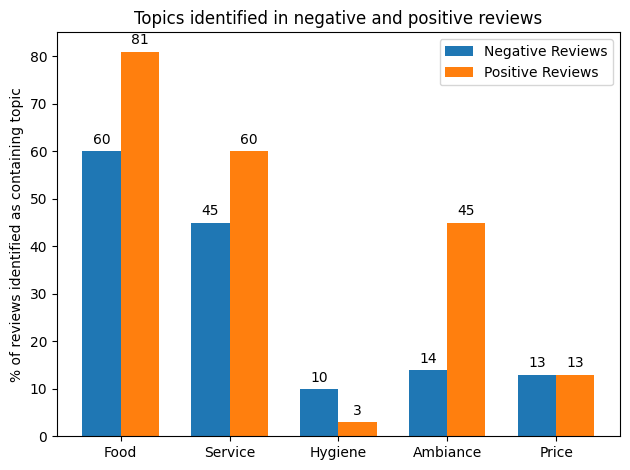

In [20]:
fields = ["Food", "Service", "Hygiene", "Ambiance", "Price"]

x = np.arange(len(fields))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pct_bad_topics, width, label='Negative Reviews')
rects2 = ax.bar(x + width/2, pct_good_topics, width, label='Positive Reviews')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('% of reviews identified as containing topic')
ax.set_title('Topics identified in negative and positive reviews')
ax.set_xticks(x)
ax.set_xticklabels(fields)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
def num_topic_present(df):

    fields = ["food", "service", "hygiene", "ambiance", "price"]
    
    df = df[fields]
    df = df.dropna()

    freqs = []
    
    for field in fields:
        #print(df[field])
        freqs.append(int(df[field].sum(axis=0)))
    return freqs

df_keyword_topics = keyword_topics(df)
num_keyword_topics = num_topic_present(df_keyword_topics.head(2000))

df_gpt_topics = pd.read_csv('classified_reviews_final.csv')
num_gpt_topics = num_topic_present(df_gpt_topics)


In [ ]:
df_keyword_topics.to_csv('keywordclassified.csv', index=False)

### Plotting

In [ ]:
print(num_keyword_topics)
print(num_gpt_topics)

pct_keyword_topics = [(num_topic/2000) * 100 for num_topic in num_keyword_topics]
pct_gpt_topics = [(num_topic/2000) * 100 for num_topic in num_gpt_topics]


fields = ["Food", "Service", "Hygiene", "Ambiance", "Price"]

x = np.arange(len(fields))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pct_keyword_topics, width, label='Percentage of reviews containing topic (keywords)')
rects2 = ax.bar(x + width/2, pct_gpt_topics, width, label='Percentage of reviews containing topic (GPT)')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('% of reviews identified as containing topic')
ax.set_title('Comparison of topic identification between keyword analysis and GPT')
ax.set_xticks(x)
ax.set_xticklabels(fields)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
df = df_gpt_topics 

df['category'] = df.apply(categorize_review, axis=1)

# Split dataset into good and bad reviews
bad_df = df[df['category'] == 0]
good_df = df[df['category'] == 2]

# Find num in catagory 
num_bad_topics = num_topic_present(bad_df)
num_good_topics = num_topic_present(good_df)


print(num_bad_topics)
print(num_good_topics)

num_rows_bad = bad_df.shape[0]
num_rows_good = good_df.shape[0]

# Get percentage of topic in each dataset
pct_bad_topics = [int((num_topic / num_rows_bad) * 100) for num_topic in num_bad_topics]
pct_good_topics = [int((num_topic / num_rows_good) * 100) for num_topic in num_good_topics]

print(pct_bad_topics)
print(pct_good_topics)



In [ ]:
fields = ["Food", "Service", "Hygiene", "Ambiance", "Price"]

x = np.arange(len(fields))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pct_bad_topics, width, label='Negative Reviews')
rects2 = ax.bar(x + width/2, pct_good_topics, width, label='Positive Reviews')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('% of reviews identified as containing topic')
ax.set_title('Topics identified in negative and positive reviews')
ax.set_xticks(x)
ax.set_xticklabels(fields)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()